# SynMall-synScore Design Script

1. This script implements the modeling, training, and prediction processes in SynMall using annotation data.  
2. Annotation data can be obtained via **SynMall → Tools → Annotation**.  
3. Notes:  
   1. Non-quantifiable or label-related data such as **ClinVar** or **GWAS** were not used.  
   2. Variant Effect Predictor (VEP) tools trained on coding SNVs annotated by **ClinVar/HGMD**, as well as synonymous mutation VEP tools, were excluded because they may overlap with our curated dataset, leading to label leakage.  
   3. For human allele frequency (AF) information, we used **gnomAD’s exome_af**, **genome_af**, and their corresponding **male** and **female** AF values as representatives to reduce redundancy.  


# 1 Process Original Format

The original features may include natural language or boolean formats. Here, we standardize and quantify them into numerical values that can be accepted by machine learning models.

In [1]:
# load in packages 

import pandas as pd
import numpy as np
import os
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt

import yaml
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, matthews_corrcoef, precision_recall_curve, roc_curve, auc

In [ ]:
def preprocess_data(directory, meta_df):
	def read_csv_variant38(file_path, usecols=None):
		"""
		Read CSV and unify Variant38 / variant38 column to 'Variant38'.
		Returns df with unified 'Variant38' column.
		"""
		df = pd.read_csv(file_path, usecols=usecols)
		df.columns = df.columns.str.strip()
		# find potential variant38
		variant_cols = [c for c in df.columns if c.lower() == 'variant38']
		if not variant_cols:
			raise ValueError(f"No Variant38 column found in {file_path}")
		# rename as 'Variant38'
		df.rename(columns={variant_cols[0]: 'Variant38'}, inplace=True)
		# dedup
		df.drop_duplicates(subset='Variant38', inplace=True)
		return df
	def _primate(directory):
		df = read_csv_variant38(f"{directory}/Allele_Frequency_Primate.csv")
		return df
	def _common(directory, meta_df):
		common_list = ["Conservation_related_features.csv", "Epigenetics_ChromHMM.csv", "Epigenetics_ENCODE.csv", "Epigenetics_Transcript_Factor.csv"]
		for name in common_list:
			df = read_csv_variant38(f"{directory}/{name}")
			meta_df = meta_df.merge(df, how='left', on='Variant38', suffixes=('', '_m'))
		return meta_df
	def _gnomad(directory):
		usecols = ['Variant38', 'exomes_AF', 'exomes_AF_XX', 'exomes_AF_XY', 'genomes_AF', 'genomes_AF_XX', 'genomes_AF_XY']
		df = read_csv_variant38(f"{directory}/Allele_Frequency_gnomAD_v4.csv", usecols=usecols)
		return df
	def _enhancer_or_promoter(directory):
		df = read_csv_variant38(f"{directory}/Epigenetics_Enhancer_or_Promoter.csv")
		df['super_enhancer'] = df['super_enhancer'].apply(lambda x: 0 if pd.isna(x) else len(str(x).split(",")))
		df["genehancer"] = df["genehancer"].str.extract(r"Score=([\d\.]+)")
		df["cage_promoter"] = df["cage_promoter"].str.count(r"chr\d+:")  
		df['cage_enhancer'] = (~df['cage_enhancer'].isna() & (df['cage_enhancer'].astype(str).str.strip() != '')).astype(int)
		return df
	def _m6(directory):
		df = read_csv_variant38(f"{directory}/Epigenetics_m6A_sites.csv", usecols=['variant38', 'peak'])
		return df
	def _oRegAnno(directory):
		df = read_csv_variant38(f"{directory}/Epigenetics_ORegAnno.csv", usecols=['Variant38', 'ORegAnno_ID'])
		df['ORegAnno_ID'] = df['ORegAnno_ID'].apply(lambda x: 0 if pd.isna(x) else len(str(x).split(";")))
		return df
	def _general_del_comp(directory):
		# NOTE if you want to perform ablation without cadd score
		# usecols = ['variant38', 'cadd_phred', 'dann_score', 'eigen_score', 'gpn_msa_score', 'integrated_fitcons_score']
		usecols = ['variant38','dann_score', 'eigen_score', 'gpn_msa_score', 'integrated_fitcons_score']
		df = read_csv_variant38(f"{directory}/Generic_deleteriousness_scores.csv", usecols=usecols)
		return df
	def _general_func_comp(directory):
		usecols = ['Variant38', 'MACIE_conserved','MACIE_regulatory', 'MACIE_anyclass','FunSeq_Score', 
				   'GenoCanyon_Score', 'FIRE_Score', 'RegSeq0', 'RegSeq1', 'RegSeq2', 'RegSeq3', 'RegSeq4', 
				   'RegSeq5', 'RegSeq6', 'RegSeq7', 'SpliceAI_acc_gain', 'SpliceAI_acc_loss', 
				   'SpliceAI_don_gain', 'SpliceAI_don_loss', 'MMSp_acceptor', 'MMSp_exon', 'MMSp_donor', 
				   'TargetScan_Score', 'mirSVR_Score', 'mirSVR_E', 'mirSVR_Aln']
		df = read_csv_variant38(f"{directory}/Generic_functional_scores.csv", usecols=usecols)
		return df
	def _transcript_info(directory):
		df = read_csv_variant38(f"{directory}/Transcript_Wise_Variant_Information.csv",
								usecols=['Variant38', 'd_esr', 'd_ess', 'd_ese', 'splice_site_acceptor', 'splice_site_donor'])
		# Use max abs
		def max_abs(series):
			return series.loc[series.abs().idxmax()]
		# TRUE/FALSE to 1/0
		def str_to_bool_max(series):
			numeric = series.fillna('FALSE').map(lambda x: 1 if x == 'TRUE' else 0)
			return numeric.max()
		grouped = df.groupby("Variant38").agg({
			"d_esr": max_abs,
			"d_ess": max_abs,
			"d_ese": max_abs,
			"splice_site_acceptor": str_to_bool_max,
			"splice_site_donor": str_to_bool_max
		}).reset_index()
		return grouped
	# === main stream ===
	result_df = _common(directory, meta_df)
	result_df = result_df.merge(_gnomad(directory), how='left', on='Variant38', suffixes=('', '_m'))
	result_df = result_df.merge(_primate(directory), how='left', on='Variant38', suffixes=('', '_m'))
	result_df = result_df.merge(_enhancer_or_promoter(directory), how='left', on='Variant38', suffixes=('', '_m'))
	result_df = result_df.merge(_m6(directory), how='left', on='Variant38', suffixes=('', '_m'))
	result_df = result_df.merge(_oRegAnno(directory), how='left', on='Variant38', suffixes=('', '_m'))
	result_df = result_df.merge(_general_del_comp(directory), how='left', on='Variant38', suffixes=('', '_m'))
	result_df = result_df.merge(_general_func_comp(directory), how='left', on='Variant38', suffixes=('', '_m'))
	result_df = result_df.merge(_transcript_info(directory), how='left', on='Variant38', suffixes=('', '_m'))
	return result_df

In [11]:
df_train_meta = pd.read_csv("../Data/Features/train_2362.txt", sep='\t', usecols=['Variant38', 'label'])
df_test_meta = pd.read_csv("../Data/Features/test_238.txt", sep='\t', usecols=['Variant38', 'label'])
train_df = preprocess_data(directory="../Data/Features/train/", meta_df=df_train_meta)
test_df = preprocess_data(directory="../Data/Features/test/", meta_df=df_test_meta)

# 2 Impute and Scale

Because feature values have different ranges and may contain missing data, we perform missing value imputation and scaling at this step.


In [13]:
def impute_and_scale(df_train: pd.DataFrame, df_test: pd.DataFrame):
	# 1 Split metainfo and feature columns
	df_train_info = df_train.iloc[:, :2]
	df_train_fea = df_train.iloc[:, 2:].copy()
	df_test_info = df_test.iloc[:, :2]
	df_test_fea = df_test.iloc[:, 2:].copy()
	# 2 Remove all NA columns
	df_train_fea.replace(["na", "NA", "nan", ""], np.nan, inplace=True)
	df_test_fea.replace(["na", "NA", "nan", ""], np.nan, inplace=True)
	empty_cols = df_train_fea.columns[df_train_fea.isna().all()].tolist()
	if empty_cols:
		print("[INFO] Dropping empty columns from training set:", empty_cols)
		df_train_fea.drop(columns=empty_cols, inplace=True)
		df_test_fea.drop(columns=empty_cols, inplace=True)
	# 3 Fill in Missing values
	imputer = IterativeImputer(random_state=2077)
	df_train_fea_imputed = pd.DataFrame(imputer.fit_transform(df_train_fea),
										columns=df_train_fea.columns,
										index=df_train_fea.index)
	df_test_fea_imputed = pd.DataFrame(imputer.transform(df_test_fea),
									   columns=df_test_fea.columns,
									   index=df_test_fea.index)
	# 4 Scale
	scaler = StandardScaler()
	df_train_scaled = pd.DataFrame(scaler.fit_transform(df_train_fea_imputed),
								   columns=df_train_fea_imputed.columns,
								   index=df_train_fea_imputed.index)
	df_test_scaled = pd.DataFrame(scaler.transform(df_test_fea_imputed),
								  columns=df_test_fea_imputed.columns,
								  index=df_test_fea_imputed.index)
	# 5 Concat meta info and feature
	df_train_result = pd.concat([df_train_info, df_train_scaled], axis=1)
	df_test_result = pd.concat([df_test_info, df_test_scaled], axis=1)

	return df_train_result, df_test_result, empty_cols, imputer, scaler

In [ ]:
df_train_result, df_test_result, empty_cols, imputer, scaler = impute_and_scale(train_df, test_df)
df_train_result.to_csv("../Data/Features/imputed_scaled/train.csv", index=False)
df_test_result.to_csv("../Data/Features/imputed_scaled/test.csv", index=False)
joblib.dump(imputer, "../Result/models/imputer.pkl")
joblib.dump(scaler, "../Result/models/scaler.pkl")
joblib.dump(empty_cols, "../Result/models/empty_cols.pkl")

In [ ]:
# NOTE if you want to perform ablation without cadd score
df_train_result, df_test_result, empty_cols, imputer, scaler = impute_and_scale(train_df, test_df)
df_train_result.to_csv("../Data/Features/imputed_scaled_withoutCADD/train.csv", index=False)
df_test_result.to_csv("../Data/Features/imputed_scaled_withoutCADD/test.csv", index=False)
joblib.dump(imputer, "../Result/models/imputer_withoutCADD.pkl")
joblib.dump(scaler, "../Result/models/scaler_withoutCADD.pkl")
joblib.dump(empty_cols, "../Result/models/empty_cols_withoutCADD.pkl")

[INFO] Dropping empty columns from training set: ['Enhancer_Finder_Limb_MKL_Scores', 'Enhancer_Finder_Brain_MKL_Scores', 'Enhancer_Finder_Heart_MKL_Scores']


['../Result/models/empty_cols_withoutCADD.pkl']

# 3 Find Best Params

Here, we use a grid search approach to find the optimal parameters for the model.


In [16]:
def load_data(df_train, y_train, vali_size=0.2, seed=913):
	"""
	Desc:
		Split training data into train and validation sets
	Args:
		df_train: training features (pd.DataFrame)
		y_train: training labels (pd.Series)
		vali_size: validation split ratio
		seed: random seed
	Returns:
		lgb_train: LightGBM training dataset
		lgb_eval: LightGBM validation dataset
	"""
	X, val_X, y, val_y = train_test_split(
		df_train, y_train,
		test_size=vali_size,
		random_state=seed,
		stratify=y_train
	)
	lgb_train = lgb.Dataset(X, y)
	lgb_eval = lgb.Dataset(val_X, val_y, reference=lgb_train)
	return lgb_train, lgb_eval


def run_cv(params, lgb_train, nfold=5, seed=913, early_stop=10):
	"""
	Desc:
		Run LightGBM cross-validation
	Args:
		params: LightGBM parameters
		lgb_train: LightGBM Dataset
		nfold: number of CV folds
		seed: random seed
		early_stop: early stopping rounds
	Returns:
		max_auc: best AUC score
		best_iter: iteration with best AUC
	"""
	cv_results = lgb.cv(
		params,
		lgb_train,
		seed=seed,
		nfold=nfold,
		metrics=['auc'],
		callbacks=[lgb.early_stopping(stopping_rounds=early_stop), lgb.log_evaluation(0)],
		eval_train_metric=True
	)
	auc_key = 'auc-mean' if 'auc-mean' in cv_results else 'valid auc-mean'
	auc_series = pd.Series(cv_results[auc_key])
	return auc_series.max(), auc_series.idxmax()


def grid_search_lgb(data, base_params=None, params_config_file=None):
	"""
	Desc:
		Perform grid search for LightGBM and train the best model
	Args:
		data: training dataset (pd.DataFrame, must contain 'label' column)
		base_params: base parameters
		seq_len: sequence length (used as key in config file)
		model_save_path: save path for the best model
		params_config_file: YAML file to store best params per seq_len
	"""
	# feature part
	X_train = data.iloc[:, 2:].astype('float64')
	y_train = data['label']
	lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
	# Default base parameters
	if base_params is None:
		base_params = {
			'boosting_type': 'gbdt',
			'objective': 'binary',
			'metric': ['binary_logloss', 'auc'],
			'nthread': 4,
			'is_unbalance': True,
			'verbosity': -1,
			'n_jobs': 4
		}
	# Search spaces
	best_params = {}
	max_auc = 0
	search_spaces = {
		'num_leaves': [15, 20, 25, 31, 40, 50, 63, 80, 100, 127],
		'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 12, -1],
		'max_bin': [31, 63, 127, 191, 255],
		'min_data_in_leaf': [5, 10, 15, 20, 30, 50, 70, 100],
		'feature_fraction': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0],
		'bagging_fraction': [0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1.0],
		'bagging_freq': [0, 1, 2, 5, 10],
		'lambda_l1': [0.0, 1e-5, 1e-3, 1e-2, 0.05, 0.1, 0.3, 0.5, 0.7, 1.0],
		'lambda_l2': [0.0, 1e-5, 1e-3, 1e-2, 0.05, 0.1, 0.3, 0.5, 0.7, 1.0],
		'min_split_gain': [0.0, 0.01, 0.05, 0.1, 0.2, 0.5, 1.0],
		'learning_rate': [0.01, 0.03, 0.05, 0.1]
	}
	# Iterative grid search
	for param_name, values in search_spaces.items():
		for value in values:
			params = {**base_params, **best_params, param_name: value}
			auc, _ = run_cv(params, lgb_train)
			if auc >= max_auc:
				max_auc = auc
				best_params[param_name] = value
				print(f"[UPDATE] {param_name}={value} | AUC={auc:.5f}")
	print("\n[Best Params Found]")
	print(best_params)
	# Save best parameters into YAML
	config_data = {}
	if params_config_file and os.path.exists(params_config_file):
		with open(params_config_file, 'r') as f:
			config_data = yaml.safe_load(f) or {}
	config_data = {**base_params, **best_params}
	if params_config_file:
		with open(params_config_file, 'w') as f:
			yaml.dump(config_data, f, sort_keys=False)

In [ ]:
grid_search_lgb(df_train_result, base_params=None, params_config_file="../Config/best_param.yaml")

In [ ]:
# NOTE if you want to perform ablation without cadd score
grid_search_lgb(df_train_result, base_params=None, params_config_file="../Config/best_param_withoutcadd.yaml")

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.965354 + 0.00239758	valid's auc: 0.917996 + 0.0142722
[UPDATE] num_leaves=15 | AUC=0.91800
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[15]	train's auc: 0.982293 + 0.00132736	valid's auc: 0.915376 + 0.013006
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[18]	train's auc: 0.990705 + 0.000894145	valid's auc: 0.914035 + 0.0135373
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.988656 + 0.00101535	valid's auc: 0.908138 + 0.0150406
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[17]	train's auc: 0.996506 + 0.000427266	valid's auc: 0.908136 + 0.0116477
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[18]	train's auc

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.


Early stopping, best iteration is:
[38]	train's auc: 0.946909 + 0.00367786	valid's auc: 0.923367 + 0.0134165
Training until validation scores don't improve for 10 rounds


[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.


Early stopping, best iteration is:
[27]	train's auc: 0.93696 + 0.00222624	valid's auc: 0.923349 + 0.0116778
Training until validation scores don't improve for 10 rounds


[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.


Early stopping, best iteration is:
[22]	train's auc: 0.935378 + 0.00377186	valid's auc: 0.922199 + 0.012778
Training until validation scores don't improve for 10 rounds


[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.


Early stopping, best iteration is:
[32]	train's auc: 0.944124 + 0.00257731	valid's auc: 0.924381 + 0.0128458
[UPDATE] max_bin=191 | AUC=0.92438
Training until validation scores don't improve for 10 rounds


[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.


Early stopping, best iteration is:
[26]	train's auc: 0.939474 + 0.00203813	valid's auc: 0.923491 + 0.0129083
Training until validation scores don't improve for 10 rounds


[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.


Early stopping, best iteration is:
[23]	train's auc: 0.937735 + 0.00340419	valid's auc: 0.923615 + 0.0141545
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[34]	train's auc: 0.94735 + 0.00313989	valid's auc: 0.924455 + 0.0132686
[UPDATE] min_data_in_leaf=10 | AUC=0.92446
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[24]	train's auc: 0.936385 + 0.00301838	valid's auc: 0.92245 + 0.0138991
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[32]	train's auc: 0.944124 + 0.00257731	valid's auc: 0.924381 + 0.0128458
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[29]	train's auc: 0.940534 + 0.00287098	valid's auc: 0.923459 + 0.01297
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[25]	train's auc: 0.937209 + 0.00205533	valid's auc: 0.922952 + 0.0148955
Tr

# 4 Training on 5-fold

Based on the optimal parameters obtained in the previous step, we perform 5-fold training and save the best prediction model from each fold.


In [18]:
def load_best_params(yaml_path):
	"""
	Load best parameters from YAML file
	Args:
		yaml_path: path to yaml config file
		seq_len: optional, key for specific sequence length
	"""
	with open(yaml_path, "r") as f:
		config = yaml.safe_load(f)
	return config


def train_kfold_and_save(data, params, n_splits=5,
						 model_dir="../Result/models/",
						 importance_dir="../Result/feature_importance/"):
	"""
	Desc:
		Train LightGBM with StratifiedKFold and save each fold's model & feature importance.
	Args:
		data: pd.DataFrame, must include 'label' column
		params: dict, LightGBM best parameters
		n_splits: number of folds
		model_dir: directory to save models
		importance_dir: directory to save feature importance
	Returns:
		models: list of trained LightGBM models
	"""
	X = data.iloc[:, 2:].astype('float64')
	y = data['label']
	skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=913)
	os.makedirs(model_dir, exist_ok=True)
	os.makedirs(importance_dir, exist_ok=True)
	models = []
	fold = 0
	
	for train_idx, val_idx in skf.split(X, y):
		fold += 1
		X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
		y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
		lgb_train = lgb.Dataset(X_train, y_train)
		lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)
		gbm = lgb.train(
			params,
			lgb_train,
			num_boost_round=1000,
			valid_sets=[lgb_val],
			callbacks=[
				lgb.early_stopping(stopping_rounds=50),
				lgb.log_evaluation(50)
			]
		)
		models.append(gbm)
		# Save model
		model_path = os.path.join(model_dir, f"lgb_fold{fold}.pkl")
		joblib.dump(gbm, model_path)
		print(f"[FOLD {fold}] Saved model to {model_path}")
		# Save feature importance
		feature_imp = pd.DataFrame({
			'Feature': X_train.columns,
			'Value': gbm.feature_importance()
		})
		feature_imp["importance"] = feature_imp.Value / feature_imp.Value.sum()
		imp_path = os.path.join(importance_dir, f"importance_fold{fold}.csv")
		feature_imp.to_csv(imp_path, index=False)
		print(f"[FOLD {fold}] Saved feature importance to {imp_path}")
	return models

In [ ]:
best_params = load_best_params("../Config/best_param.yaml")
models = train_kfold_and_save(
	df_train_result,
	params=best_params,
	n_splits=5,
	model_dir="../Result/models/",
	importance_dir="../Result/feature_importance/"
)

In [ ]:
# NOTE if you want to perform ablation without cadd score
best_params = load_best_params("../Config/best_param_withoutcadd.yaml")
models = train_kfold_and_save(
	df_train_result,
	params=best_params,
	n_splits=5,
	model_dir="../Result/models_withoutCADD/",
	importance_dir="../Result/feature_importance_withoutCADD/"
)

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.350618	valid_0's auc: 0.899566
Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.361418	valid_0's auc: 0.905242
[FOLD 1] Saved model to ../Result/models_withoutCADD/lgb_fold1.pkl
[FOLD 1] Saved feature importance to ../Result/feature_importance_withoutCADD/importance_fold1.csv
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.327716	valid_0's auc: 0.91571
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.330884	valid_0's auc: 0.917704
[FOLD 2] Saved model to ../Result/models_withoutCADD/lgb_fold2.pkl
[FOLD 2] Saved feature importance to ../Result/feature_importance_withoutCADD/importance_fold2.csv
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.286674	valid_0's auc: 0.934214
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.296667	valid_0's auc: 0.9361

# 5 Ensembl predict

Based on the best models from each fold, perform ensemble prediction and performance evaluation on the independent test set.

In [ ]:
def predict_ensemble(models, X_test):
	"""
	Make predictions with an ensemble of models by averaging probabilities.
	Args:
		models: list of LightGBM models
		X_test: pd.DataFrame, test features
	Returns:
		preds: averaged prediction probabilities
	"""
	preds = np.zeros((X_test.shape[0], len(models)))
	for i, model in enumerate(models):
		preds[:, i] = model.predict(X_test, num_iteration=model.best_iteration)
	return preds.mean(axis=1)

def evaluate_predictions(y_true, y_pred, threshold=0.5):
	"""
	Evaluate classification performance.
	Args:
		y_true: ground truth labels (0/1)
		y_pred: predicted probabilities
		threshold: cutoff for classification (default=0.5)
	Returns:
		dict of metrics
	"""
	y_bin = (y_pred >= threshold).astype(int)

	metrics = {
		"AUROC": roc_auc_score(y_true, y_pred),
		"AUPR": average_precision_score(y_true, y_pred),
	}
	print(metrics)
	return metrics
# feature
X_test = df_test_result.iloc[:, 2:].astype('float64')
# label
y_test = df_test_result["label"].values
# pred result
y_pred = predict_ensemble(models, X_test)

# metrics
metrics_result = df_test_result.copy()
metrics_result["y_pred"] = y_pred
metrics_result["y_pred_label"] = (y_pred >= 0.5).astype(int)
# metrics_result.to_csv("../Result/prediction/SynMall.pred.csv", index=False)
# NOTE if you want to perform ablation without cadd score
metrics_result.to_csv("../Result/prediction_withoutCADD/SynMall.pred.csv", index=False)
metrics = evaluate_predictions(y_test, y_pred)

{'AUROC': np.float64(0.9221806369606668), 'AUPR': np.float64(0.9451852345733106), 'F1': 0.847926267281106, 'Accuracy': 0.8613445378151261}


In [47]:
metrics_result = pd.read_csv("../Result/prediction/SynMall.pred.csv")
y_test = metrics_result['label']
y_pred = metrics_result['y_pred']
metrics = evaluate_predictions(y_test, y_pred)

{'AUROC': np.float64(0.9262057764282183), 'AUPR': np.float64(0.9481093924213255), 'F1': 0.8727272727272727, 'Accuracy': 0.8823529411764706}


# 6 Benchmarks

- benchmark synScore with other VEPs
- Since some VEPs have missing values (unable to predict some samples), we conducted subset and pairwise comparison.
	- subset: a small subset that all VEPs have prediction results.
	- pairwise: take synScore and VEP `x`, calculate metrics based on their intersection.

In [ ]:
# 1 prepare data
metrics_result = pd.read_csv("../Result/prediction/SynMall.pred.csv")
benchmark = metrics_result[['Variant38', 'label', 'y_pred']]
benchmark.rename(columns={'y_pred': 'synScore', 'Variant38': 'variant38'}, inplace=True)

usecols_com=['variant38',
			 'cadd_phred',
			 'dann_score',
			 'eigen_score',
			 'fathmm_mkl_score',
			 'fathmm_xf_score',
			 'capice_score',
			 'trap_score',
			 'phd_snpg_score',
			 'gpn_msa_score',
			 'integrated_fitcons_score']
usecols_snv = ['variant38',
			   'endsm_score',
			   'frdsm_score',
			   'prdsm_score',
			   'usdsm_score',
			   'sliva_score',
			   'sedsm_score']
df_common = pd.read_csv("../Data/Features/test/Generic_deleteriousness_scores.csv", usecols=usecols_com)
df_ssnv = pd.read_csv("../Data/Features/test/Synonymous_specific_deleteriousness_scores.csv", usecols=usecols_snv)


benchmark = benchmark.merge(df_common, how='left', left_on='variant38', right_on='variant38', suffixes=('', '_m'))
benchmark = benchmark.merge(df_ssnv, how='left', left_on='variant38', right_on='variant38', suffixes=('', '_m'))
benchmark.columns = ['variant38', 'label', 'synScore', 'CADD', 'DANN', 'EIGEN', 
				 'FATHMM-MKL', 'FATHMM-XF', 'CAPICE', 'TraP', 'PhD-SNPg', 'GPN-MSA', 'fitCons', 
				 'EnDSM', 'frDSM', 'PrDSM', 'usDSM', 'SliVA', 'seDSM']

benchmark.head()

,variant38,label,synScore,CADD,DANN,EIGEN,FATHMM-MKL,FATHMM-XF,CAPICE,TraP,PhD-SNPg,GPN-MSA,fitCons,EnDSM,frDSM,PrDSM,usDSM,SliVA,seDSM
0,10_63190900_T/A,0,0.200820,7.412,0.753749,0.0001,0.77849,0.011355,0.2489,0.112,0.180,-4.15,0.706548,0.27410,0.38151,0.313566,0.577,0.046,0.454001
1,10_87933155_T/C,0,0.350701,14.240,0.716433,1.5343,0.80347,0.008063,0.0016,0.075,0.024,-4.59,0.722319,0.25672,0.24150,0.297329,0.774,0.011,0.412856
2,10_96223832_C/T,0,0.221050,6.178,0.407401,0.8778,0.32963,0.008557,0.0004,0.090,0.013,-2.44,0.671770,0.19297,0.21351,0.154173,0.287,0.039,0.354929
3,10_97601978_G/A,0,0.221272,5.372,0.499751,0.0467,0.88155,0.028218,0.0091,0.000,0.042,-3.07,0.554377,0.36605,0.18851,0.303627,0.611,0.026,0.434700
4,11_117993368_A/C,0,0.182052,5.629,0.740331,NaN,0.01347,0.007443,0.0003,0.008,0.005,2.22,0.645754,0.22342,0.13433,0.029526,0.380,0.062,0.294763


## Subset

1. In the subset comparison, all missing values from the compared tools are removed, and benchmarking is performed on the subset where all tools provide prediction scores.  
2. The orientation of the GPN-MSA score is such that smaller values indicate higher functionality; therefore, we inverted the scores when calculating AUC/AUPR.


In [64]:
# 1 Calculate AUC/AUPR
def calculate_metrics(sampled_data):
	results = {}  
	sampled_data['GPN-MSA'] = -sampled_data['GPN-MSA']  # the direction of GPN-MSA is not the higher the more deleterious
	for col in sampled_data.columns[2:]:
		y_true = sampled_data["label"]
		y_score = sampled_data[col]  
		metrics = {
			"AUC": roc_auc_score(y_true, y_score) if len(set(y_true)) > 1 else np.nan,
			"AUPR": average_precision_score(y_true, y_score) if len(set(y_true)) > 1 else np.nan,
		}
		results[col] = metrics  
	results_df = pd.DataFrame(results).T
	return results_df

result_data_nona = benchmark.dropna()
print(f"[INFO] Drop nans: {len(result_data_nona)}")
calculate_metrics(result_data_nona)

[INFO] Drop nans: 191


,AUC,AUPR
synScore,0.922340,0.951180
CADD,0.878828,0.929713
DANN,0.716678,0.719146
EIGEN,0.680436,0.699507
FATHMM-MKL,0.747962,0.797216
FATHMM-XF,0.836308,0.895942
CAPICE,0.830029,0.872988
TraP,0.883620,0.928588
PhD-SNPg,0.752919,0.801445
GPN-MSA,0.721139,0.790350


### Draw AUC

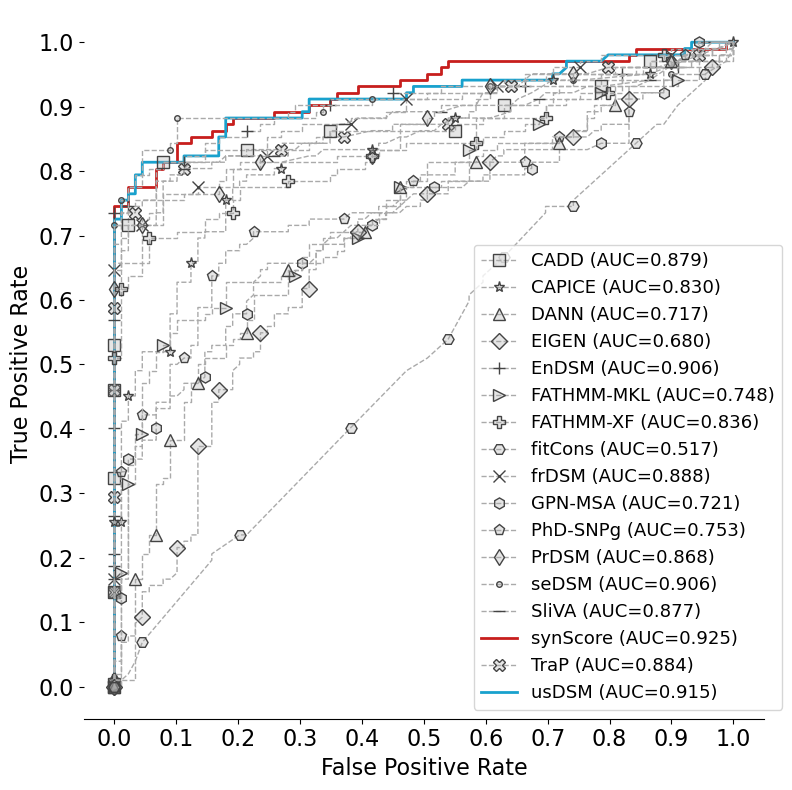

In [26]:
from matplotlib.colors import to_rgba

def draw_auc(data, save_path=None):
	selected_methods = data.columns[2:]
	auc_scores = {}
	roc_data = {}
	for method in selected_methods:
		y_true = data['label'].astype(int)
		y_score = data[method].astype(float)
		fpr, tpr, _ = roc_curve(y_true, y_score)
		roc_auc = auc(fpr, tpr)
		auc_scores[method] = roc_auc
		roc_data[method] = (fpr, tpr)

	# rank by auc
	sorted_auc = sorted(auc_scores.items(), key=lambda x: x[1], reverse=True)
	best = sorted_auc[0][0]
	second_best = sorted_auc[1][0] if len(sorted_auc) > 1 else None

	# Set color, linestyle, marker
	colors = {m: '#AAA' for m in selected_methods}
	colors[best] = '#c71e1d'
	if second_best:
		colors[second_best] = '#18a1cd'
	linestyles = {m: '-' if m in [best, second_best] else '--' for m in selected_methods}
	markers = ['o', 's', '^', 'D', '>', 'P', '*', 'X', 'p', 'h', 'H', '+', 'x', 'd', '|', '_', '.']
	marker_map = {m: markers[i % len(markers)] if m not in [best, second_best] else None 
					for i, m in enumerate(selected_methods)}

	# plot
	plt.figure(figsize=(8, 8))
	for m, _ in sorted_auc:
		fpr, tpr = roc_data[m]
		marker = marker_map[m]
		if marker:
			plt.plot(fpr, tpr, 
					color=colors[m], 
					linestyle=linestyles[m],
					marker=marker, 
					markevery=0.1, 
					markersize=8,
					markerfacecolor=to_rgba(colors[m], alpha=0.3),
					markeredgecolor='#444',
					label=f'{m} (AUC={auc_scores[m]:.3f})',
					linewidth=1)
		else:
			plt.plot(fpr, tpr,
					color=colors[m],
					linestyle=linestyles[m],
					label=f'{m} (AUC={auc_scores[m]:.3f})',
					linewidth=2)
			
	# sort handles and labels alphabetically by method name (case-insensitive)
	handles, labels = plt.gca().get_legend_handles_labels()
	sorted_pairs = sorted(zip(labels, handles), key=lambda x: x[0].lower())
	labels, handles = zip(*sorted_pairs)
	# plt.legend(handles, labels, loc='lower right',  bbox_to_anchor=(1.04, 0), ncol=1, frameon=False, fontsize=14)
	plt.legend(handles, labels, loc='lower right',  bbox_to_anchor=(1.04, 0), ncol=1, frameon=True, fontsize=13)

	# label/ticks
	plt.xlabel('False Positive Rate', fontsize=16, fontfamily='DejaVu Sans')
	plt.ylabel('True Positive Rate', fontsize=16, fontfamily='DejaVu Sans')
	plt.xticks(np.arange(0, 1.1, 0.1), fontsize=16, fontfamily='DejaVu Sans')
	plt.yticks(np.arange(0, 1.1, 0.1), fontsize=16, fontfamily='DejaVu Sans')

	# prettier
	ax = plt.gca()
	ax.spines['top'].set_visible(False)
	ax.spines['left'].set_visible(False)
	ax.spines['right'].set_visible(False)
	ax.tick_params(axis='y', left=True)
	plt.tight_layout()
	if save_path:
		plt.savefig(save_path, bbox_inches='tight')
	plt.show()

# draw_auc(result_data_nona, save_path="../Result/plot/subset.auc.jpg")
draw_auc(result_data_nona, save_path="None")

### Draw AUPR

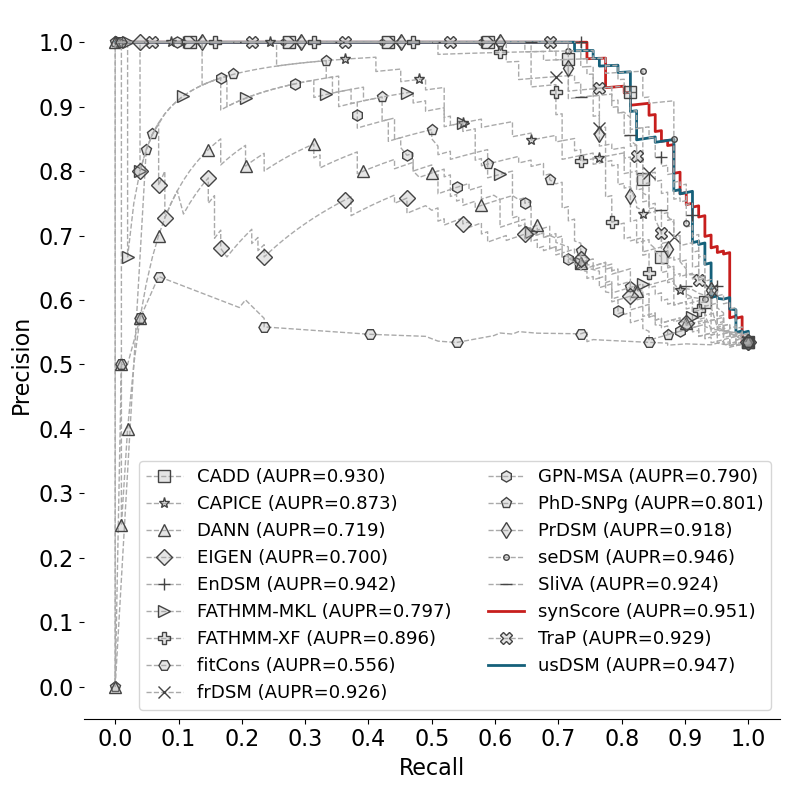

In [27]:
def draw_aupr(data, save_path):
	selected_methods = data.columns[2:]
	# calculate AUPR
	aupr_scores = {}
	pr_data = {}
	for method in selected_methods:
		y_true = data['label'].astype(int)
		y_score = data[method].astype(float)
		precision, recall, _ = precision_recall_curve(y_true, y_score)
		aupr = average_precision_score(y_true, y_score) if len(set(y_true)) > 1 else np.nan
		aupr_scores[method] = aupr
		pr_data[method] = (recall, precision)

	# rank by AUPR
	sorted_aupr = sorted(aupr_scores.items(), key=lambda x: x[1], reverse=True)
	best = sorted_aupr[0][0]
	second_best = sorted_aupr[1][0] if len(sorted_aupr) > 1 else None

	# Set color, linestyle, marker
	colors = {m: '#AAA' for m in selected_methods}
	colors[best] = '#c71e1d'
	if second_best:
		colors[second_best] = '#15607a'

	linestyles = {m: '-' if m in [best, second_best] else '--' for m in selected_methods}
	markers = ['o', 's', '^', 'D', '>', 'P', '*', 'X', 'p', 'h', 'H', '+', 'x', 'd', '|', '_', '.']
	marker_map = {m: markers[i % len(markers)] if m not in [best, second_best] else None 
					for i, m in enumerate(selected_methods)}

	# plot
	plt.figure(figsize=(8, 8))
	for m, _ in sorted_aupr:
		recall, precision = pr_data[m]
		marker = marker_map[m]
		label_text = f'{m} (AUPR={round(aupr_scores[m], 3):.3f})'  # 四舍五入并保留两位小数
		if marker:
			plt.plot(recall, precision,
						color=colors[m],
						linestyle=linestyles[m],
						marker=marker,
						markevery=0.1,
						markersize=8,
						markerfacecolor=to_rgba(colors[m], alpha=0.3),
						markeredgecolor='#444',
						label=label_text,
						linewidth=1)
		else:
			plt.plot(recall, precision,
						color=colors[m],
						linestyle=linestyles[m],
						label=label_text,
						linewidth=2)

	# sort handles and labels alphabetically by method name
	handles, labels = plt.gca().get_legend_handles_labels()
	sorted_pairs = sorted(zip(labels, handles), key=lambda x: x[0].lower())
	labels, handles = zip(*sorted_pairs)
	plt.legend(handles, labels, loc='lower right', ncol=2, frameon=True, fontsize=13)

	# labels and ticks
	plt.xlabel('Recall', fontsize=16, fontfamily='DejaVu Sans')
	plt.ylabel('Precision', fontsize=16, fontfamily='DejaVu Sans')
	plt.xticks(np.arange(0, 1.1, 0.1), fontsize=16, fontfamily='DejaVu Sans')
	plt.yticks(np.arange(0, 1.1, 0.1), fontsize=16, fontfamily='DejaVu Sans')

	# remove boundary
	ax = plt.gca()
	ax.spines['top'].set_visible(False)
	ax.spines['left'].set_visible(False)
	ax.spines['right'].set_visible(False)
	ax.tick_params(axis='y', left=True)

	plt.tight_layout()
	if save_path:
		plt.savefig(save_path, bbox_inches='tight')
	plt.show()

# draw_aupr(result_data_nona, save_path="../Result/plot/subset.aupr.jpg")
draw_aupr(result_data_nona, save_path=None)

## Pairwise

1. In the pairwise comparison, our extracted prediction tool (synScore) is compared individually with each other tool.  
2. We take the subset without missing values for synScore and the target tool `x`, and evaluate both tools on this subset.


In [65]:
from sklearn.metrics import roc_auc_score , average_precision_score
	

def pairwise_metrics(df):
	df['GPN-MSA'] = -df['GPN-MSA']
	constant =df.iloc[:, :3]
	compare = df.iloc[:, 3:]
	auc_constant_list, aupr_constant_list, auc_compare_list, aupr_compare_list, notnan = [], [], [], [], []
	for col in compare.columns:
		tmp_df = pd.concat([constant, compare[col]], axis=1)
		tmp_df.dropna(inplace=True)
		y_label = tmp_df["label"].tolist()
		# our method
		auc_constant_list.append(roc_auc_score(y_label, tmp_df['synScore']))
		aupr_constant_list.append(average_precision_score(y_label,  tmp_df['synScore']))
		# auc_constant_list.append(roc_auc_score(y_label, tmp_df['synScore_new']))
		# aupr_constant_list.append(average_precision_score(y_label,  tmp_df['synScore_new']))
		# compared methods
		auc_compare_list.append(roc_auc_score(y_label, tmp_df[col]))
		aupr_compare_list.append(average_precision_score(y_label, tmp_df[col]))
		notnan.append(len(df) - len(tmp_df))
	df_result = pd.DataFrame({'VEP': list(compare.columns), 
						   	  'AUC_our': auc_constant_list,
							  'AUPR_our': aupr_constant_list,
							  'AUC_compare': auc_compare_list,
							  'AUPR_compare': aupr_compare_list,
							  'amount': notnan})
	print(df_result)
	return df_result
pairwise_df = pairwise_metrics(benchmark)

           VEP   AUC_our  AUPR_our  AUC_compare  AUPR_compare  amount
0         CADD  0.926206  0.948109     0.882706      0.924599       0
1         DANN  0.926206  0.948109     0.726361      0.700514       0
2        EIGEN  0.923356  0.945899     0.699138      0.682357      28
3   FATHMM-MKL  0.926206  0.948109     0.763152      0.781750       0
4    FATHMM-XF  0.927347  0.948991     0.842358      0.886265      28
5       CAPICE  0.921088  0.949522     0.841257      0.879964      14
6         TraP  0.928469  0.950029     0.888251      0.923305       2
7     PhD-SNPg  0.926206  0.948109     0.794400      0.816453       0
8      GPN-MSA  0.926206  0.948109     0.753513      0.790659       0
9      fitCons  0.924706  0.946767     0.509834      0.512079      26
10       EnDSM  0.926206  0.948109     0.920274      0.945231       0
11       frDSM  0.928469  0.950029     0.900316      0.927954       2
12       PrDSM  0.928944  0.950566     0.885340      0.920978       3
13       usDSM  0.92

### Draw AUC

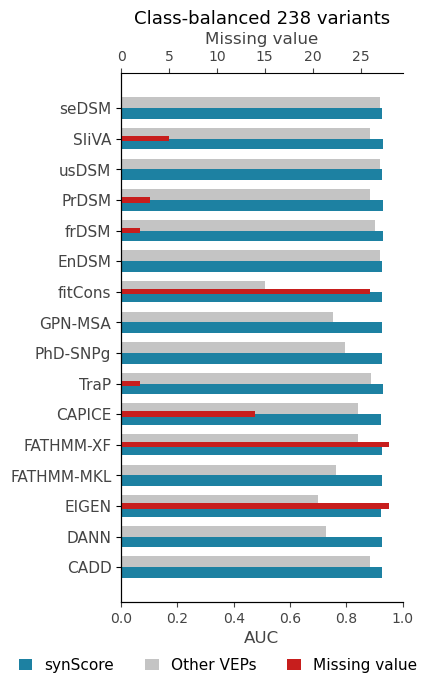

In [69]:
def draw_pairwise_auc(data, save_path):
	veps = data["VEP"].tolist()
	y = np.arange(len(data))
	height = 0.35
	auc_our = data["AUC_our"].tolist()
	auc_compare = data["AUC_compare"].tolist()
	amounts = data["amount"].tolist()
	fig, ax1 = plt.subplots(figsize=(4.5, 7))
	# fig, ax1 = plt.subplots(figsize=(5, 6.5))
	# AUC
	ax1.barh(y - height/2, auc_our, height, label="synScore", color="#1d81a2")
	# ax1.barh(y - height/2, auc_our, height, label="synScore_new", color="#1d81a2")
	ax1.barh(y + height/2, auc_compare, height, label="Other VEPs", color="#c4c4c4")
	ax1.set_xlim(0, 1)
	ax1.set_xlabel("AUC", fontsize=12, color='#444')
	ax1.set_yticks(y)
	ax1.set_yticklabels(veps, fontsize=11, color='#444')
	ax1.tick_params(axis="x", labelsize=10, color='#444', labelcolor='#444')
	ax1.spines["top"].set_visible(False)
	ax1.spines["right"].set_visible(False)
	ax1.set_title(f"Class-balanced 238 variants", fontsize=13)
	# Missing value
	ax2 = ax1.twiny()
	ax2.barh(y, amounts, height*0.5, label="Missing value", color="#c71e1d")
	ax2.set_xlabel("Missing value", fontsize=12, color='#444')
	ax2.tick_params(axis="x", labelsize=10, labelcolor='#444', color='#444')
	ax2.spines["right"].set_visible(False)
	# Legend
	lines, labels = [], []
	for ax in [ax1, ax2]:
		lns, lbls = ax.get_legend_handles_labels()
		lines.extend(lns)
		labels.extend(lbls)
	ax1.legend(lines, labels, fontsize=11,  bbox_to_anchor=[1.1, -0.08], ncol=3, frameon=False, handlelength=0.9)
	plt.tight_layout()
	if save_path:
		plt.savefig(save_path, bbox_inches='tight', dpi=300)
	plt.show()

draw_pairwise_auc(pairwise_df, save_path="../Result/plot/pairwise.auc.jpg")
# draw_pairwise_auc(pairwise_df, save_path=None)

### Draw AUPR

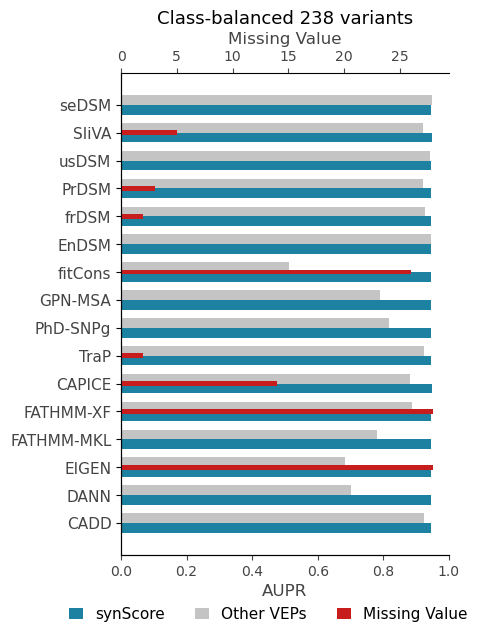

In [29]:
def draw_pairwise_aupr(data, save_path):
	veps = data["VEP"].tolist()
	y = np.arange(len(data))
	height = 0.35
	aupr_our = pairwise_df["AUPR_our"].tolist()
	aupr_compare = pairwise_df["AUPR_compare"].tolist()
	amounts = data["amount"].tolist()
	fig, ax1 = plt.subplots(figsize=(5, 6.5))
	# AUC
	ax1.barh(y - height/2, aupr_our, height, label="synScore", color="#1d81a2")
	# ax1.barh(y - height/2, aupr_our, height, label="synScore_new", color="#1d81a2")
	ax1.barh(y + height/2, aupr_compare, height, label="Other VEPs", color="#c4c4c4")
	ax1.set_xlim(0, 1)
	ax1.set_xlabel("AUPR", fontsize=12, color='#444')
	ax1.set_yticks(y)
	ax1.set_yticklabels(veps, fontsize=11, color='#444')
	ax1.tick_params(axis="x", labelsize=10, color='#444', labelcolor='#444')
	ax1.spines["top"].set_visible(False)
	ax1.spines["right"].set_visible(False)
	ax1.set_title(f"Class-balanced 238 variants", fontsize=13)
	# Missing value
	ax2 = ax1.twiny()
	ax2.barh(y, amounts, height*0.5, label="Missing Value", color="#c71e1d")
	ax2.set_xlabel("Missing Value", fontsize=12, color='#444')
	ax2.tick_params(axis="x", labelsize=10, labelcolor='#444', color='#444')
	ax2.spines["right"].set_visible(False)
	# Legend
	lines, labels = [], []
	for ax in [ax1, ax2]:
		lns, lbls = ax.get_legend_handles_labels()
		lines.extend(lns)
		labels.extend(lbls)
	ax1.legend(lines, labels, fontsize=11,  bbox_to_anchor=[1.1, -0.08], ncol=3, frameon=False, handlelength=0.9)
	plt.tight_layout()
	if save_path:
		plt.savefig(save_path, bbox_inches='tight')
	plt.show()

# draw_pairwise_aupr(pairwise_df, save_path="../Result/plot/pairwise.aupr.jpg")
draw_pairwise_aupr(pairwise_df, save_path=None)

# 7 Interpretation

/tmp/ipykernel_3224240/9457216.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topN['category'] = [
/tmp/ipykernel_3224240/9457216.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topN['color'] = topN['category'].map(colors_set)


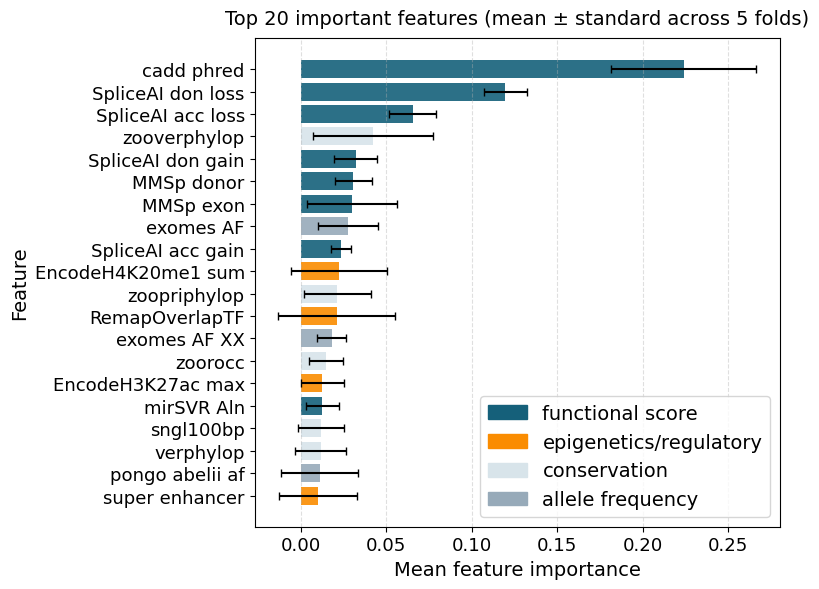

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import glob

# 1. Read results from all folds
files = sorted(glob.glob("../Result/feature_importance/importance_fold*.csv"))
dfs = [pd.read_csv(f) for f in files]

# 2. Merge all feature importance data
imp_all = pd.concat([df[['Feature', 'importance']] for df in dfs], keys=range(len(dfs)), names=['fold'])

# 3. Calculate mean and standard deviation
imp_stats = imp_all.groupby('Feature')['importance'].agg(['mean', 'std']).sort_values('mean', ascending=False)

# 4. Select Top N features (e.g., top 20)
topN = imp_stats.head(20)
topN['category'] = [
    'functional score', 'functional score', 'functional score', 'conservation',
    'functional score', 'functional score', 'functional score', 'allele frequency',
    'functional score', 'epigenetics/regulatory', 'conservation', 'epigenetics/regulatory',
    'allele frequency', 'conservation', 'epigenetics/regulatory', 'functional score',
    'conservation', 'conservation', 'allele frequency', 'epigenetics/regulatory'
]

# Color settings
colors_set = {
    'functional score': '#15607a',
    'epigenetics/regulatory': '#fa8c00',
    'conservation': '#d8e4ea',
    'allele frequency': '#97aab9',
}

# Map colors according to categories
topN['color'] = topN['category'].map(colors_set)

# 5. Plotting
plt.figure(figsize=(8, 6))
plt.barh(
    [item.replace('_', ' ') for item in topN.index[::-1]],
    topN['mean'][::-1],
    xerr=topN['std'][::-1],
    color=topN['color'][::-1],
    alpha=0.9,
    ecolor='black',
    capsize=3,
)

plt.xlabel('Mean feature importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Top 20 important features (mean ± standard across 5 folds)', fontsize=14, pad=10)

# Adjust axis tick font size
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.grid(axis='x', linestyle='--', alpha=0.4)

# Legend
legend_patches = [mpatches.Patch(color=c, label=cat) for cat, c in colors_set.items()]
plt.legend(handles=legend_patches, 
           loc='lower right', 
           fontsize=14,
           frameon=True)

plt.tight_layout()
plt.show()

# 8 Ablation w/o CADD

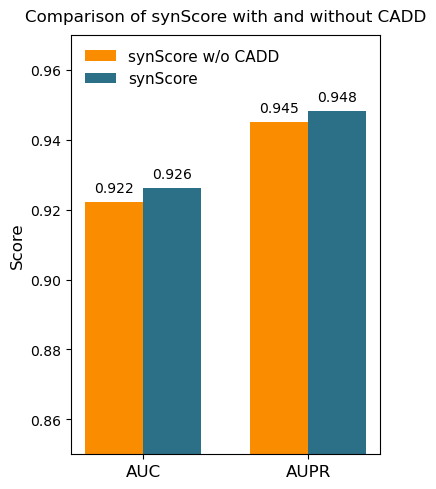

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Data
synScore_withoutcadd = {'AUC': 0.9222, 'AUPR': 0.9452}
synScore = {'AUC': 0.9262, 'AUPR': 0.9481}

metrics = ['AUC', 'AUPR']
values_without = [synScore_withoutcadd[m] for m in metrics]
values_with = [synScore[m] for m in metrics]

x = np.arange(len(metrics))  # x-axis positions
width = 0.35  # bar width

# Plotting
fig, ax = plt.subplots(figsize=(4, 5))
bars1 = ax.bar(x - width/2, values_without, width, label='synScore w/o CADD', color='#fa8c00')
bars2 = ax.bar(x + width/2, values_with, width, label='synScore', color='#2c7087')

# Add value labels
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.002, f'{height:.3f}', ha='center', va='bottom', fontsize=10)

# Configure axes
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_ylim(0.85, 0.97)
ax.set_title('Comparison of synScore with and without CADD', fontsize=12, pad=10)

# Legend
ax.legend(fontsize=11, frameon=False, loc='upper left')

plt.tight_layout()
plt.show()